[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_ZpVdMxSJ5NcLM119HNmbKuI8a7NE2T0)

INSTALANDO A BIBLIOTECA QUE SERÁ UTILIZADA

In [ ]:
%pip install -U mip yfinance requests pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from mip import Model, maximize, xsum, BINARY, OptimizationStatus
import requests
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

CONSULTANDO AS 30 MAIORES EMPRESAS DE ENERGIA DOS EUA

In [ ]:
url = "https://investnews.com.br/financas/veja-a-lista-completa-dos-bdrs-disponiveis-para-pessoas-fisicas-na-b3/"
r = requests.get(url)
html = r.text
df_stocks = pd.read_html(html, header=0)[0]
#df_stocks.head(10)
df_filtro=df_stocks.loc[(df_stocks['SETOR']=='Energia') & (df_stocks['PAÍS DE ORIGEM']=='EUA')]
df=pd.DataFrame(df_filtro)
df1=df.head(30)
df1

,EMPRESA,CÓDIGO,SETOR,PAÍS DE ORIGEM
11,AES CORP,A1ES34,Energia,EUA
25,ALLIANT ENERGY CORP,A1EN34,Energia,EUA
34,AMEREN CORP,A1EE34,Energia,EUA
67,ATMOS ENERGY CORP,A1TM34,Energia,EUA
128,CENTERPOINT,C1NP34,Energia,EUA
150,CMS ENERGY CORP,C1MS34,Energia,EUA
157,CONSOLIDATED EDISON INC,E1DI34,Energia,EUA
197,DOMINION ENE,D1OM34,Energia,EUA
204,DTE ENERGY CO,D1TE34,Energia,EUA
208,EATON CORP PLC,E1TN34,Energia,EUA


DETERMINANDO OS 10 ATIVOS QUE SERÃO TESTADOS NO PERÍODO DE (01/2021 ATÉ 01/2023)

In [ ]:
lista_acoes = ['A1ES34.SA', 'A1EN34.SA', 'A1EE34.SA', 'A1TM34.SA', 'C1MS34.SA', 'E1DI34.SA', 'D1OM34.SA', 'D1TE34.SA', 'E1TN34.SA', 'E1TR34.SA']
historico = yf.download(lista_acoes, start='2021-01-01', end='2023-01-01')[['Close']]


[*********************100%***********************]  10 of 10 completed


CARREGANDO A LISTA DE AÇÕES PARA A ANÁLISE

In [ ]:
lista = []
for acoes in lista_acoes:
  lista.append({'acoes': acoes,'historico': historico['Close'][acoes].values.tolist()})

NORMALIZAÇÃO DOS DADOS

In [ ]:
x = np.arange(1,len(lista[0]['historico'])+1,1)
x

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [ ]:
for valores_y in lista:
  minimo = np.min(valores_y['historico'])
  maximo = np.max(valores_y['historico'])
  valores_y['historico'] = (valores_y['historico'] - minimo)/(maximo - minimo)

PLOT DA SÉRIE TEMPORAL DOS ATIVOS

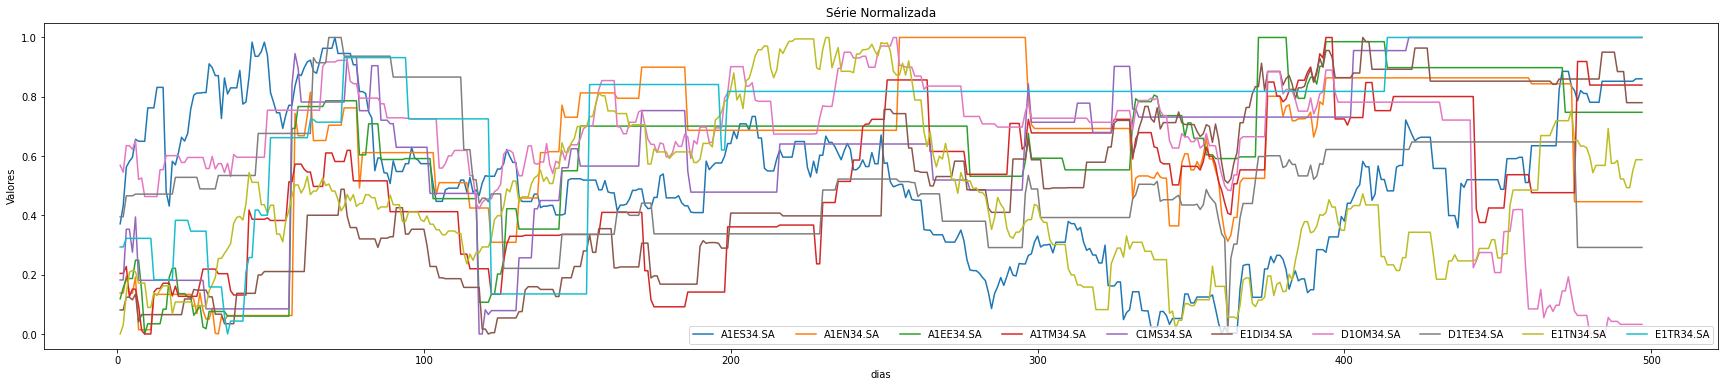

In [ ]:
plt.figure(figsize=(30,6))
plt.title('Série Normalizada')
plt.xlabel('dias')
plt.ylabel('Valores')
for valores_y in lista:
  plt.plot(x, valores_y['historico'], label=valores_y['acoes'])
plt.legend(ncol=len(lista))
plt.show()

CONFIGURANDO OS PARÂMETROS DE TREINAMENTO

In [ ]:
treinamento = {}
teste = {}
for valores_y in lista:
  taxa_treinamento = 0.8
  treinamento_valores = int(taxa_treinamento*(len(x)));
  treinamento_x = x[0:treinamento_valores] 
  teste_x = x[treinamento_valores:]
  treinamento_y = valores_y['historico'][0:treinamento_valores]
  teste_y = valores_y['historico'][treinamento_valores:]
  treinamento[valores_y['acoes']] = np.array(list(zip(treinamento_x, treinamento_y)))
  teste[valores_y['acoes']] = np.array(list(zip(teste_x, teste_y)))

ORGANIZAÇÃO E PREPARO DOS DADOS

In [ ]:
def create_dataset(n_X, look_back):
  dataX = []
  dataY = []
  for i in range(len(n_X)-look_back):
    a = n_X[i:(i+look_back), ]
    print('a: {}'.format(a))
    dataX.append(a)
    dataY.append(n_X[i + look_back, ])
  print('dataX: {}'.format(dataX))
  return np.array(dataX), np.array(dataY)

In [ ]:
def prepare_data(series, look_back):
  X, y =[],[]
  n = len(series)
  for i in range(n - look_back):
    end = i + look_back
    if end <= n:
      seq_x = series[i:end,1]
      seq_y = series[end,1]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
treinamento_x = {}
teste_x = {}
treinamento_y = {}
teste_y = {}
for acoes in lista_acoes:
  look_back = 2
  local_train_x, treinamento_y[acoes] = prepare_data(treinamento[acoes], look_back)
  local_test_x, teste_y[acoes] = prepare_data(teste[acoes], look_back)
  n_features = 1 #monovariate series
  treinamento_x[acoes] = local_train_x.reshape((local_train_x.shape[0],local_train_x.shape[1],n_features))
  teste_x[acoes] = local_test_x.reshape((local_test_x.shape[0],local_test_x.shape[1],n_features))

CRIAÇÃO DO MODELO

In [ ]:
modelo = {}
for acoes in lista_acoes:
  steps = treinamento_x[acoes].shape[1]
  n_features = treinamento_x[acoes].shape[2]
  epochs = 20
  units = 100
  tf.random.set_seed(8888) # Setting seed to ensure reproducibility.
  modelo[acoes] = Sequential()
  input_layer=(steps, n_features)
  modelo[acoes].add(LSTM(units,return_sequences = True,input_shape = input_layer))
  modelo[acoes].add(Dropout(0.2))
  modelo[acoes].add(LSTM(128,input_shape = input_layer))
  modelo[acoes].add(Dense(1))


In [ ]:
for acoes in lista_acoes:
  print(acoes)
  print(modelo[acoes].summary())

A1ES34.SA
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_340 (LSTM)             (None, 2, 100)            40800     
                                                                 
 dropout_170 (Dropout)       (None, 2, 100)            0         
                                                                 
 lstm_341 (LSTM)             (None, 128)               117248    
                                                                 
 dense_170 (Dense)           (None, 1)                 129       
                                                                 
Total params: 158,177
Trainable params: 158,177
Non-trainable params: 0
_________________________________________________________________
None
A1EN34.SA
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

CALCULANDO O ERRO QUADRÁTICO MÉDIO DE CADA ATIVO PARA SER UTILIZADO NO PROCESSO DE OTIMIZAÇÃO

In [ ]:
for acoes in lista_acoes:
 modelo[acoes].compile(loss = 'mean_squared_error', optimizer = 'adam')

TREINAMENTO DO MODELO

In [ ]:
historico = {}
for acoes in lista_acoes:
  historico[acoes] = modelo[acoes].fit(treinamento_x[acoes], treinamento_y[acoes],epochs = epochs,batch_size = 70,verbose = False,shuffle = False,validation_split = 0.3)
  hist = pd.DataFrame(historico[acoes].history)
  hist.head()

In [ ]:
for acoes in lista_acoes:
  print(f'\n{acoes}')
  modelo[acoes].evaluate(teste_x[acoes], teste_y[acoes], batch_size=64)


A1ES34.SA
2/2 [==============================] - 0s 13ms/step - loss: 0.0052

A1EN34.SA
2/2 [==============================] - 0s 14ms/step - loss: 0.0033

A1EE34.SA
2/2 [==============================] - 0s 11ms/step - loss: 0.0026

A1TM34.SA
2/2 [==============================] - 0s 17ms/step - loss: 0.0078

C1MS34.SA
2/2 [==============================] - 0s 13ms/step - loss: 0.0047

E1DI34.SA
2/2 [==============================] - 0s 13ms/step - loss: 0.0051

D1OM34.SA
2/2 [==============================] - 0s 12ms/step - loss: 0.0369

D1TE34.SA
2/2 [==============================] - 0s 15ms/step - loss: 0.0036

E1TN34.SA
2/2 [==============================] - 0s 12ms/step - loss: 0.0059

E1TR34.SA
2/2 [==============================] - 0s 14ms/step - loss: 0.0037


ANÁLISE DO ERRO DURANTE O TREINAMENTO

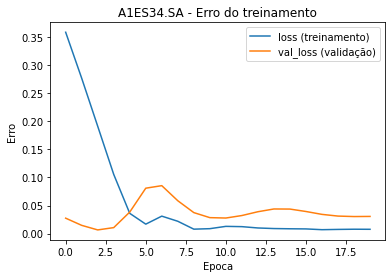

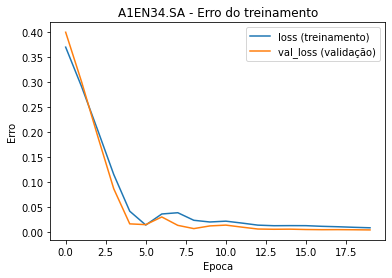

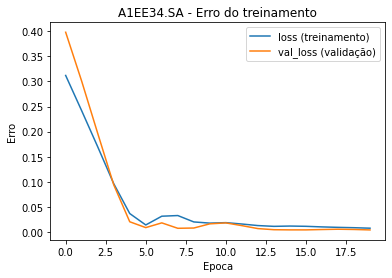

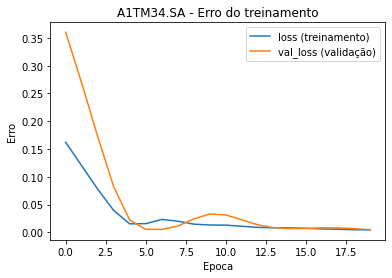

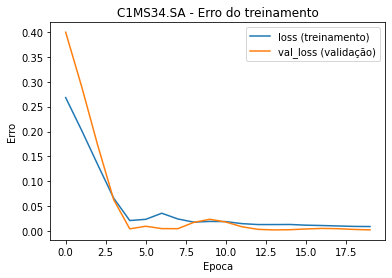

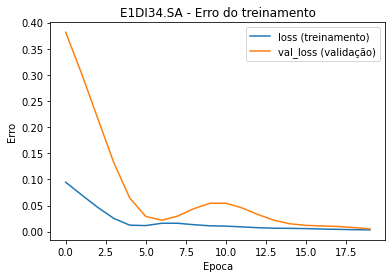

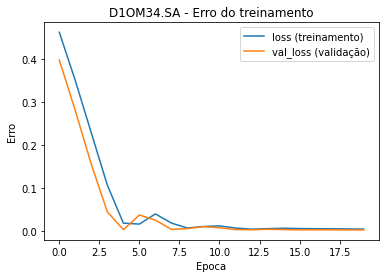

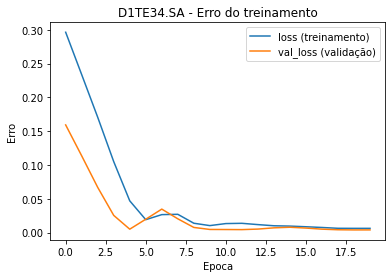

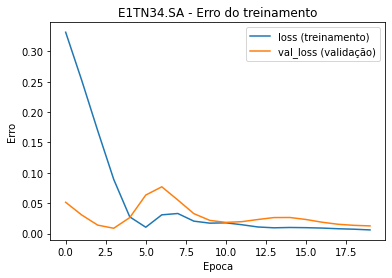

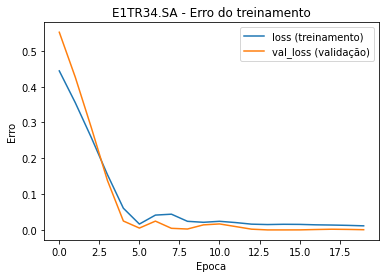

In [ ]:
for acoes in lista_acoes:
 plt.plot(historico[acoes].history['loss'])
 plt.plot(historico[acoes].history['val_loss'])
 plt.title(f'{acoes} - Erro do treinamento')
 plt.ylabel('Erro')
 plt.xlabel('Epoca')
 plt.legend(['loss (treinamento)', 'val_loss (validação)'], loc='upper right')
 plt.show()

TESTANDO A PREDIÇÃO DO MODELO

In [ ]:
predicao = {}
for acoes in lista_acoes:
  predicao[acoes] = modelo[acoes].predict(teste_x[acoes])


4/4 [==============================] - 1s 7ms/step


COMPARATIVO DO VALOR OBSERVADO E O VALOR ESTIMADO

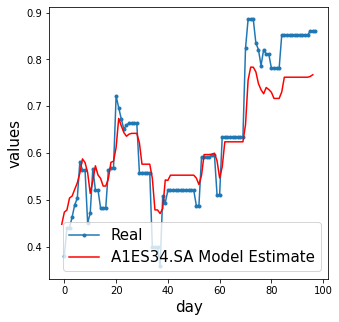

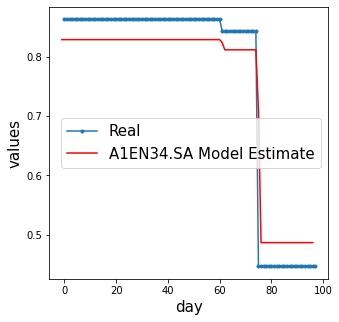

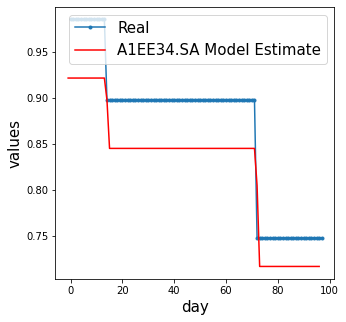

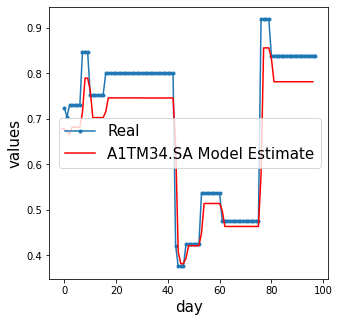

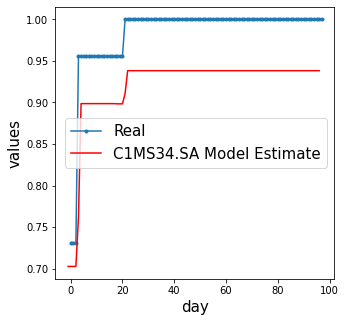

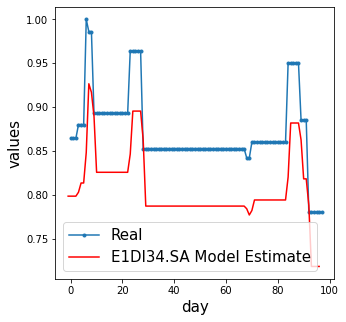

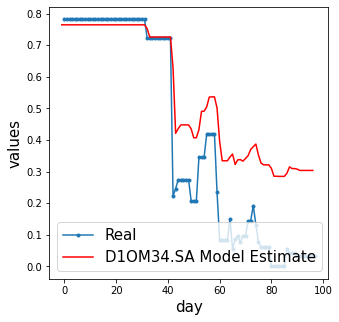

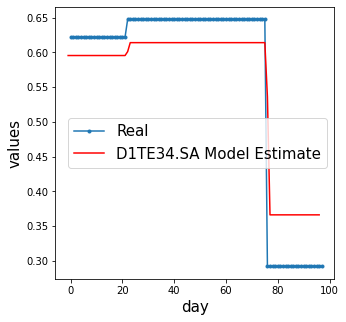

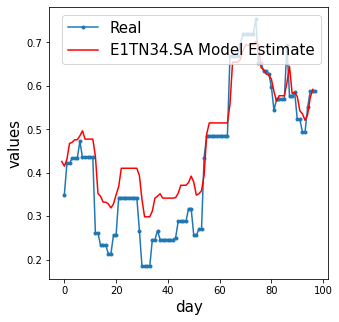

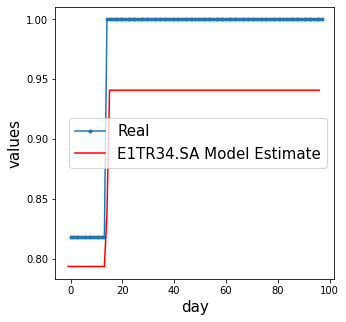

In [ ]:
observado = {}
estimado = {}
for acoes in lista_acoes:
  look_back = 1
  observado[acoes] = teste_y[acoes]
  plt.figure(figsize=(5,5))
  plt.plot(list(range(len(observado[acoes]))),observado[acoes],marker='.',label='Real')
  estimado[acoes] = [w[0] for w in predicao[acoes]]
  plt.plot(list(np.arange(len(predicao[acoes]))-look_back),estimado[acoes],'r',label=f'{acoes} Model Estimate')
  plt.ylabel('values', size=15)
  plt.xlabel('day', size=15)
  plt.legend(fontsize=15)
  plt.show()

CALCULANDO O GANHO DE CADA ATIVO

In [ ]:
ganho = {}
for acoes in lista_acoes:
  tomorrow_prediciton = modelo[acoes].predict([teste_x[acoes][-1]])
  ganho[acoes] = (tomorrow_prediciton[1][0] - teste_x[acoes][-1][1][0]) / tomorrow_prediciton[1][0]
  print(f'{acoes}: Observado: {teste_x[acoes][-1][1][0]}  Estimado: {tomorrow_prediciton[1][0]} Ganho: {(ganho[acoes]) * 10:2.2f}%')

1/1 [==============================] - 0s 26ms/step
A1ES34.SA: Observado: 0.8605464129125793  Estimado: 0.26519808173179626 Ganho: -22.45%
1/1 [==============================] - 0s 26ms/step
A1EN34.SA: Observado: 0.446121259510737  Estimado: 0.17364609241485596 Ganho: -15.69%
1/1 [==============================] - 0s 27ms/step
A1EE34.SA: Observado: 0.7476217940913437  Estimado: 0.24341334402561188 Ganho: -20.71%
1/1 [==============================] - 0s 28ms/step
A1TM34.SA: Observado: 0.8394733110503393  Estimado: 0.24722707271575928 Ganho: -23.96%
1/1 [==============================] - 0s 27ms/step
C1MS34.SA: Observado: 1.0  Estimado: 0.2998528778553009 Ganho: -23.35%
1/1 [==============================] - 0s 26ms/step
E1DI34.SA: Observado: 0.7800953719852978  Estimado: 0.2261657416820526 Ganho: -24.49%
1/1 [==============================] - 0s 25ms/step
D1OM34.SA: Observado: 0.03241117041176802  Estimado: 0.13573592901229858 Ganho: 7.61%
1/1 [==============================] - 0s 30ms

APLICANDO O PROCESSO DE OTIMIZAÇÃO

In [ ]:
valores_y_coef = list(ganho.values())
rest_coef = [1] * 10
ind = 3

CONFIGURANDO O MODDELO DE OTIMIZAÇÃO

In [ ]:
size = range(len(valores_y_coef))
model = Model('pack')
mip_vars = [model.add_var(var_type=BINARY) for i in size]

In [ ]:
valores_y_func = xsum(valores_y_coef[i] * mip_vars[i] for i in size)
model.objective = maximize(valores_y_func)

In [ ]:
model += xsum(rest_coef[i] * mip_vars[i] for i in size) <= ind
print(f'The model has {model.num_cols} variable(s), {model.num_rows} restiction(s) e {model.num_nz} zero(s)')

The model has 10 variable(s), 1 restiction(s) e 10 zero(s)


In [ ]:
opt_status = model.optimize(max_seconds=10)
if opt_status == OptimizationStatus.OPTIMAL:
  print('Otimizado')
else:
  print('Falha')

Successfully optimized


RESULTADO DO MODELO DE OTIMIZAÇÃO

In [ ]:
selecao = [list(ganho.keys())[i] for i in size if mip_vars[i].x >= 0.99]
print(f'Itens Selecionados: {selecao}')
print(f'Retorno: {model.objective_value}')

Itens Selecionados: ['D1OM34.SA']
Retorno: 0.7614448334895314


OBSERVA-SE QUE PARA OS ATIVOS TESTADOS APENAS D1OM34.SA APRESENTOU GANHO ESTIMADO
